In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.mpl.geoaxes as geoaxes
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics.pairwise import haversine_distances
import seaborn as sns

gd_src = '../geodata/{}/{}-c005-s010-vw-pr.geojson'
onemil_src = './node_modules/preprocessing/data/1Mdataset.csv'
nc_src = '../well_data/src_data.csv'

In [2]:
def load_gd(level='uni'):
    return gpd.read_file(
        gd_src.format(level, level)
    )

def disp_gd(level):
    gd = load_gd(level)
    ax = gplt.polyplot(
        gd, 
        projection=gcrs.AlbersEqualArea(), 
        edgecolor='black', 
        linewidth=0.15,
        figsize=(33,33),
    )
    ax.add_artist(ScaleBar(1))
    plt.savefig(f'./poster/{level}_region_outline.png')
    return
    
def disp_all_levels():
    for level in ['div', 'dis', 'upa', 'uni', 'mou']:
        disp_gd(level)

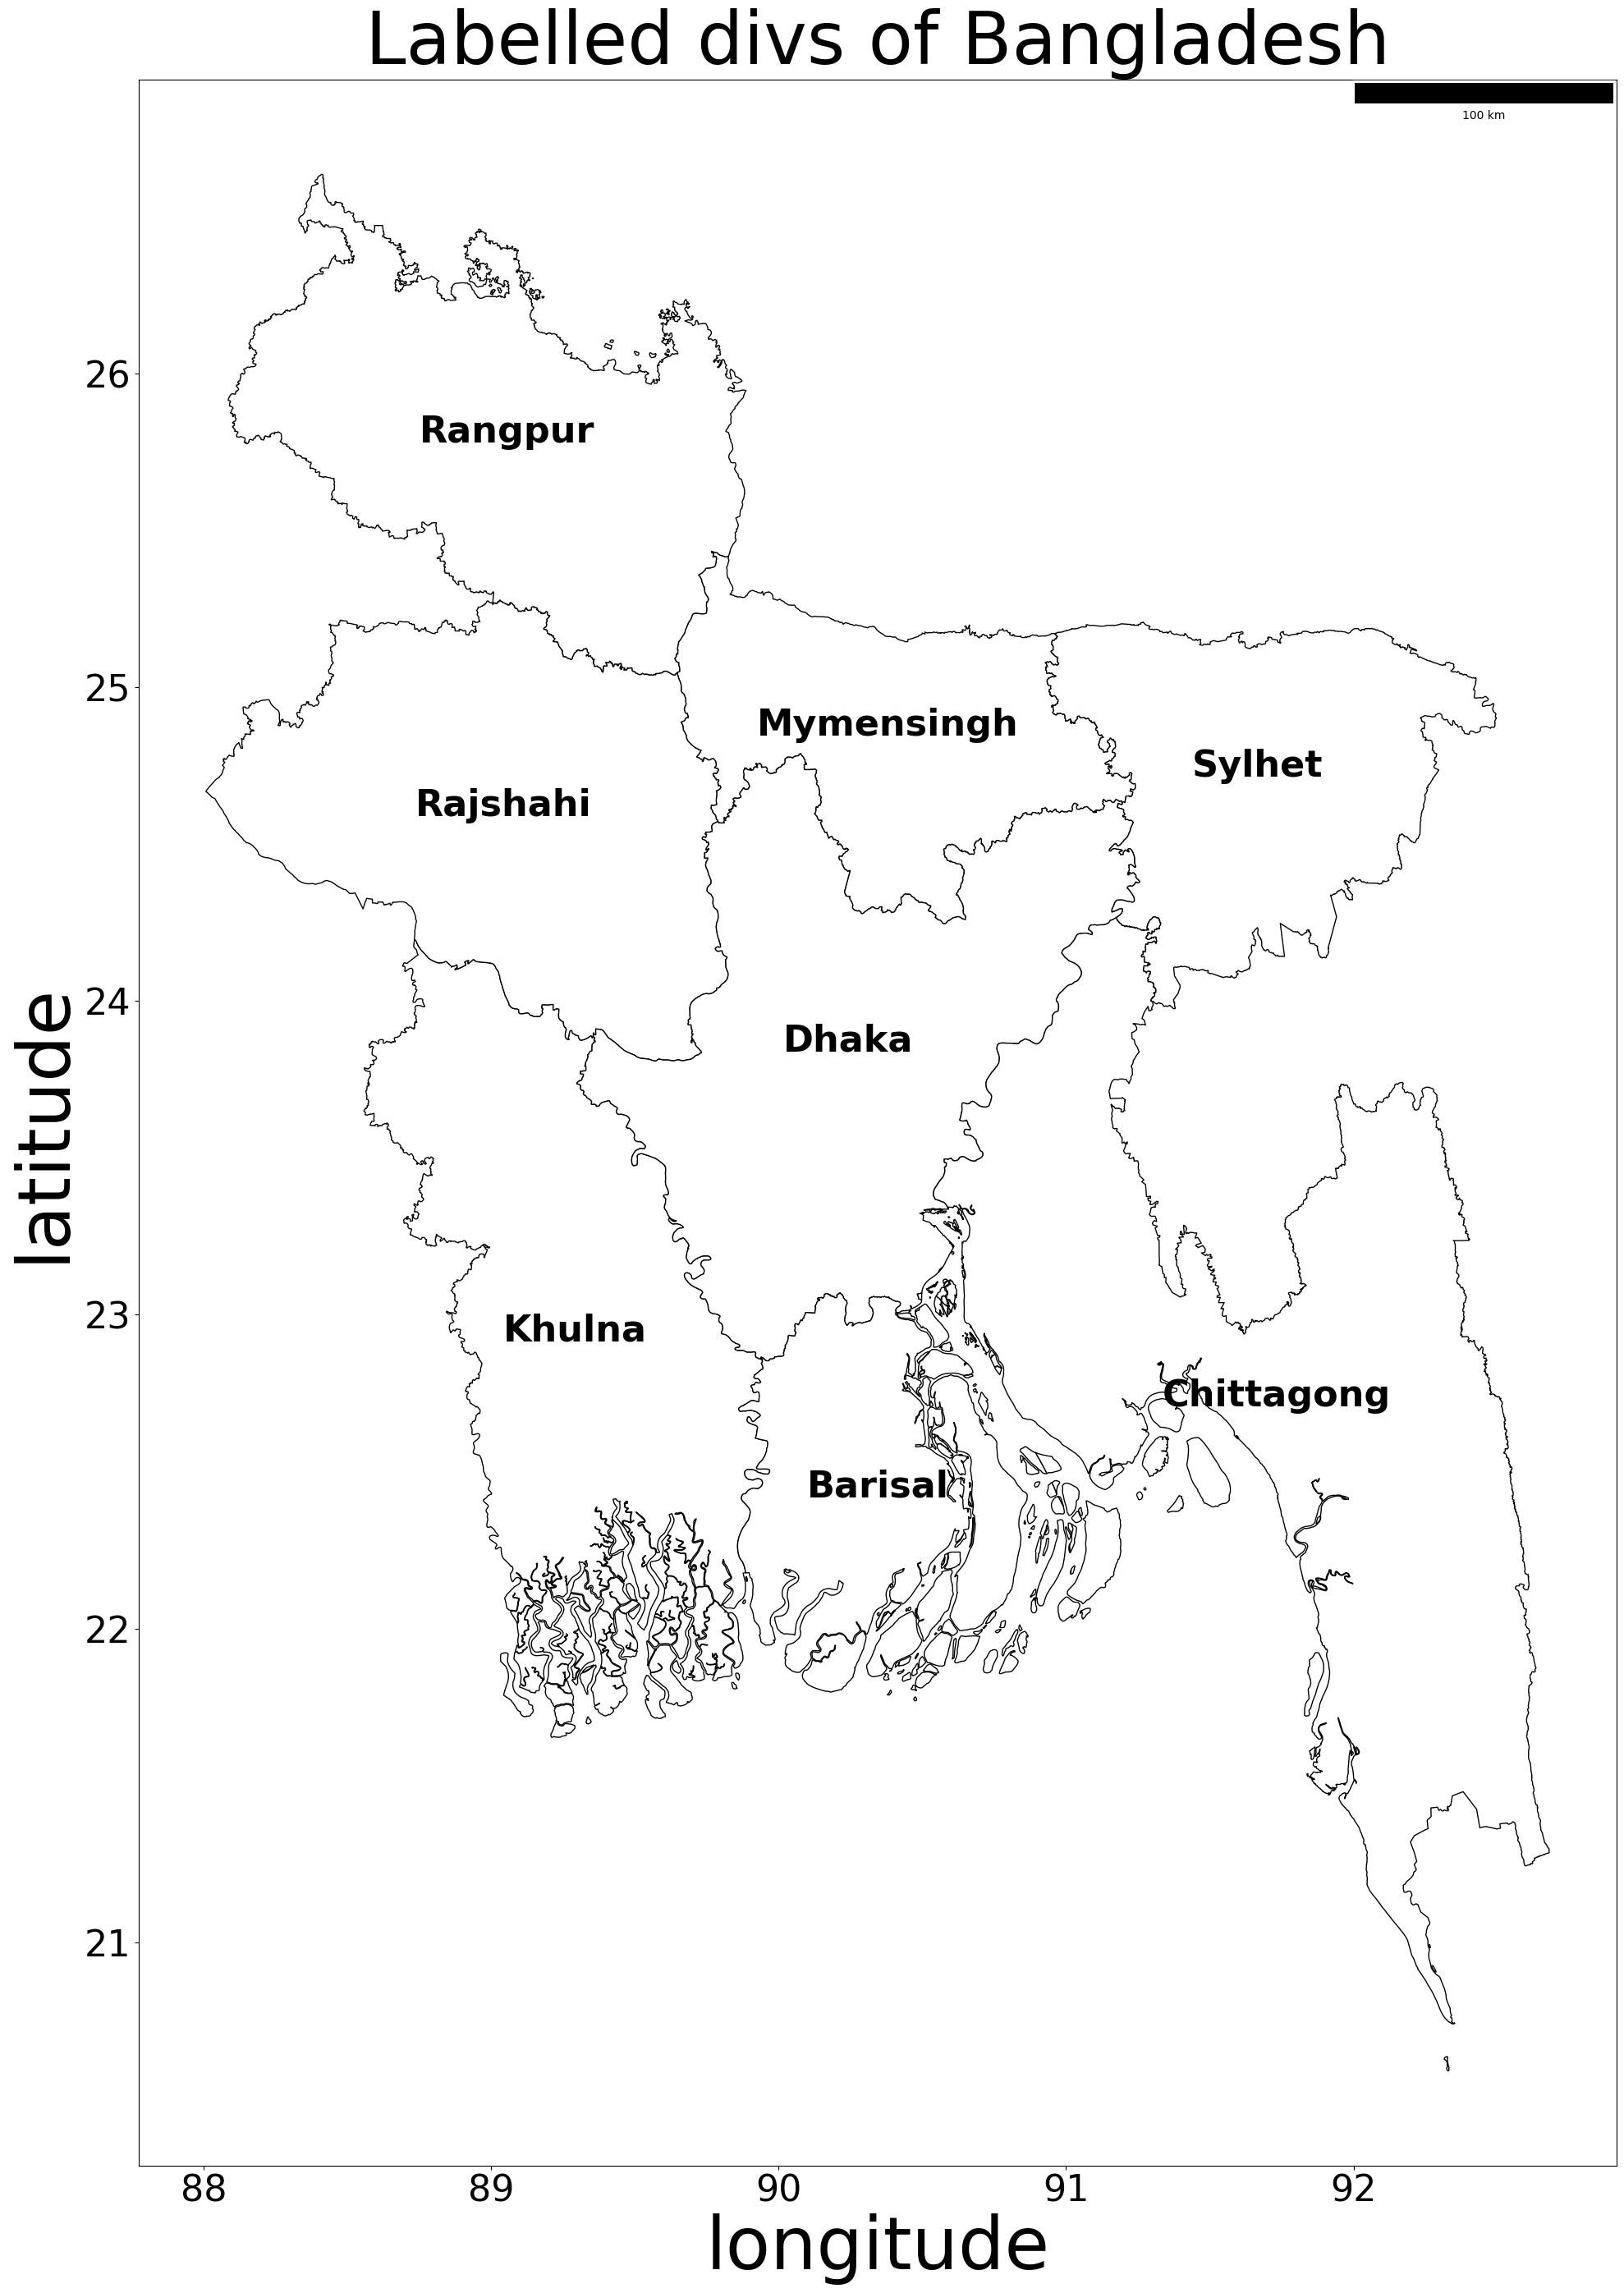

In [3]:
def labelled_div_map(level='div'):
    # code from https://stackoverflow.com/questions/38899190/geopandas-label-polygons
    gd = load_gd(level)

    ax = gd.plot(
        figsize=(33,33),
        linewidth=1,
        edgecolor='black', 
        facecolor='white',
    )

    gd.apply(
        lambda x:
        ax.annotate(
            text=x[level],
            xy=x.geometry.centroid.coords[0],
            ha='center',
            fontsize=32,
            fontweight='bold'
        ), 
        axis=1
    );
    
    # code from https://stackoverflow.com/questions/70256031/how-do-you-display-the-scale-in-meters-the-north-arrow-and-the-axes-in-latitude
    A=[-88*np.pi/180.,21*np.pi/180.] #Latitude of interest here 40.7 deg, longitude -74.5
    B=[-89*np.pi/180.,21*np.pi/180.] #Latitude of interest here 40.7 deg, longitude -74.5+1
    dx=(6371000) * haversine_distances([A,B])[0,1]
    ax.add_artist(ScaleBar(dx=dx,units="m")) 
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)

    
    plt.xlabel('longitude', fontsize=64)
    plt.ylabel('latitude', fontsize=64)
    plt.title(f'Labelled {level}s of Bangladesh', fontsize=64)
    plt.savefig(f'./poster/{level}_labelled_region_outline.png')
    return

labelled_div_map('div')

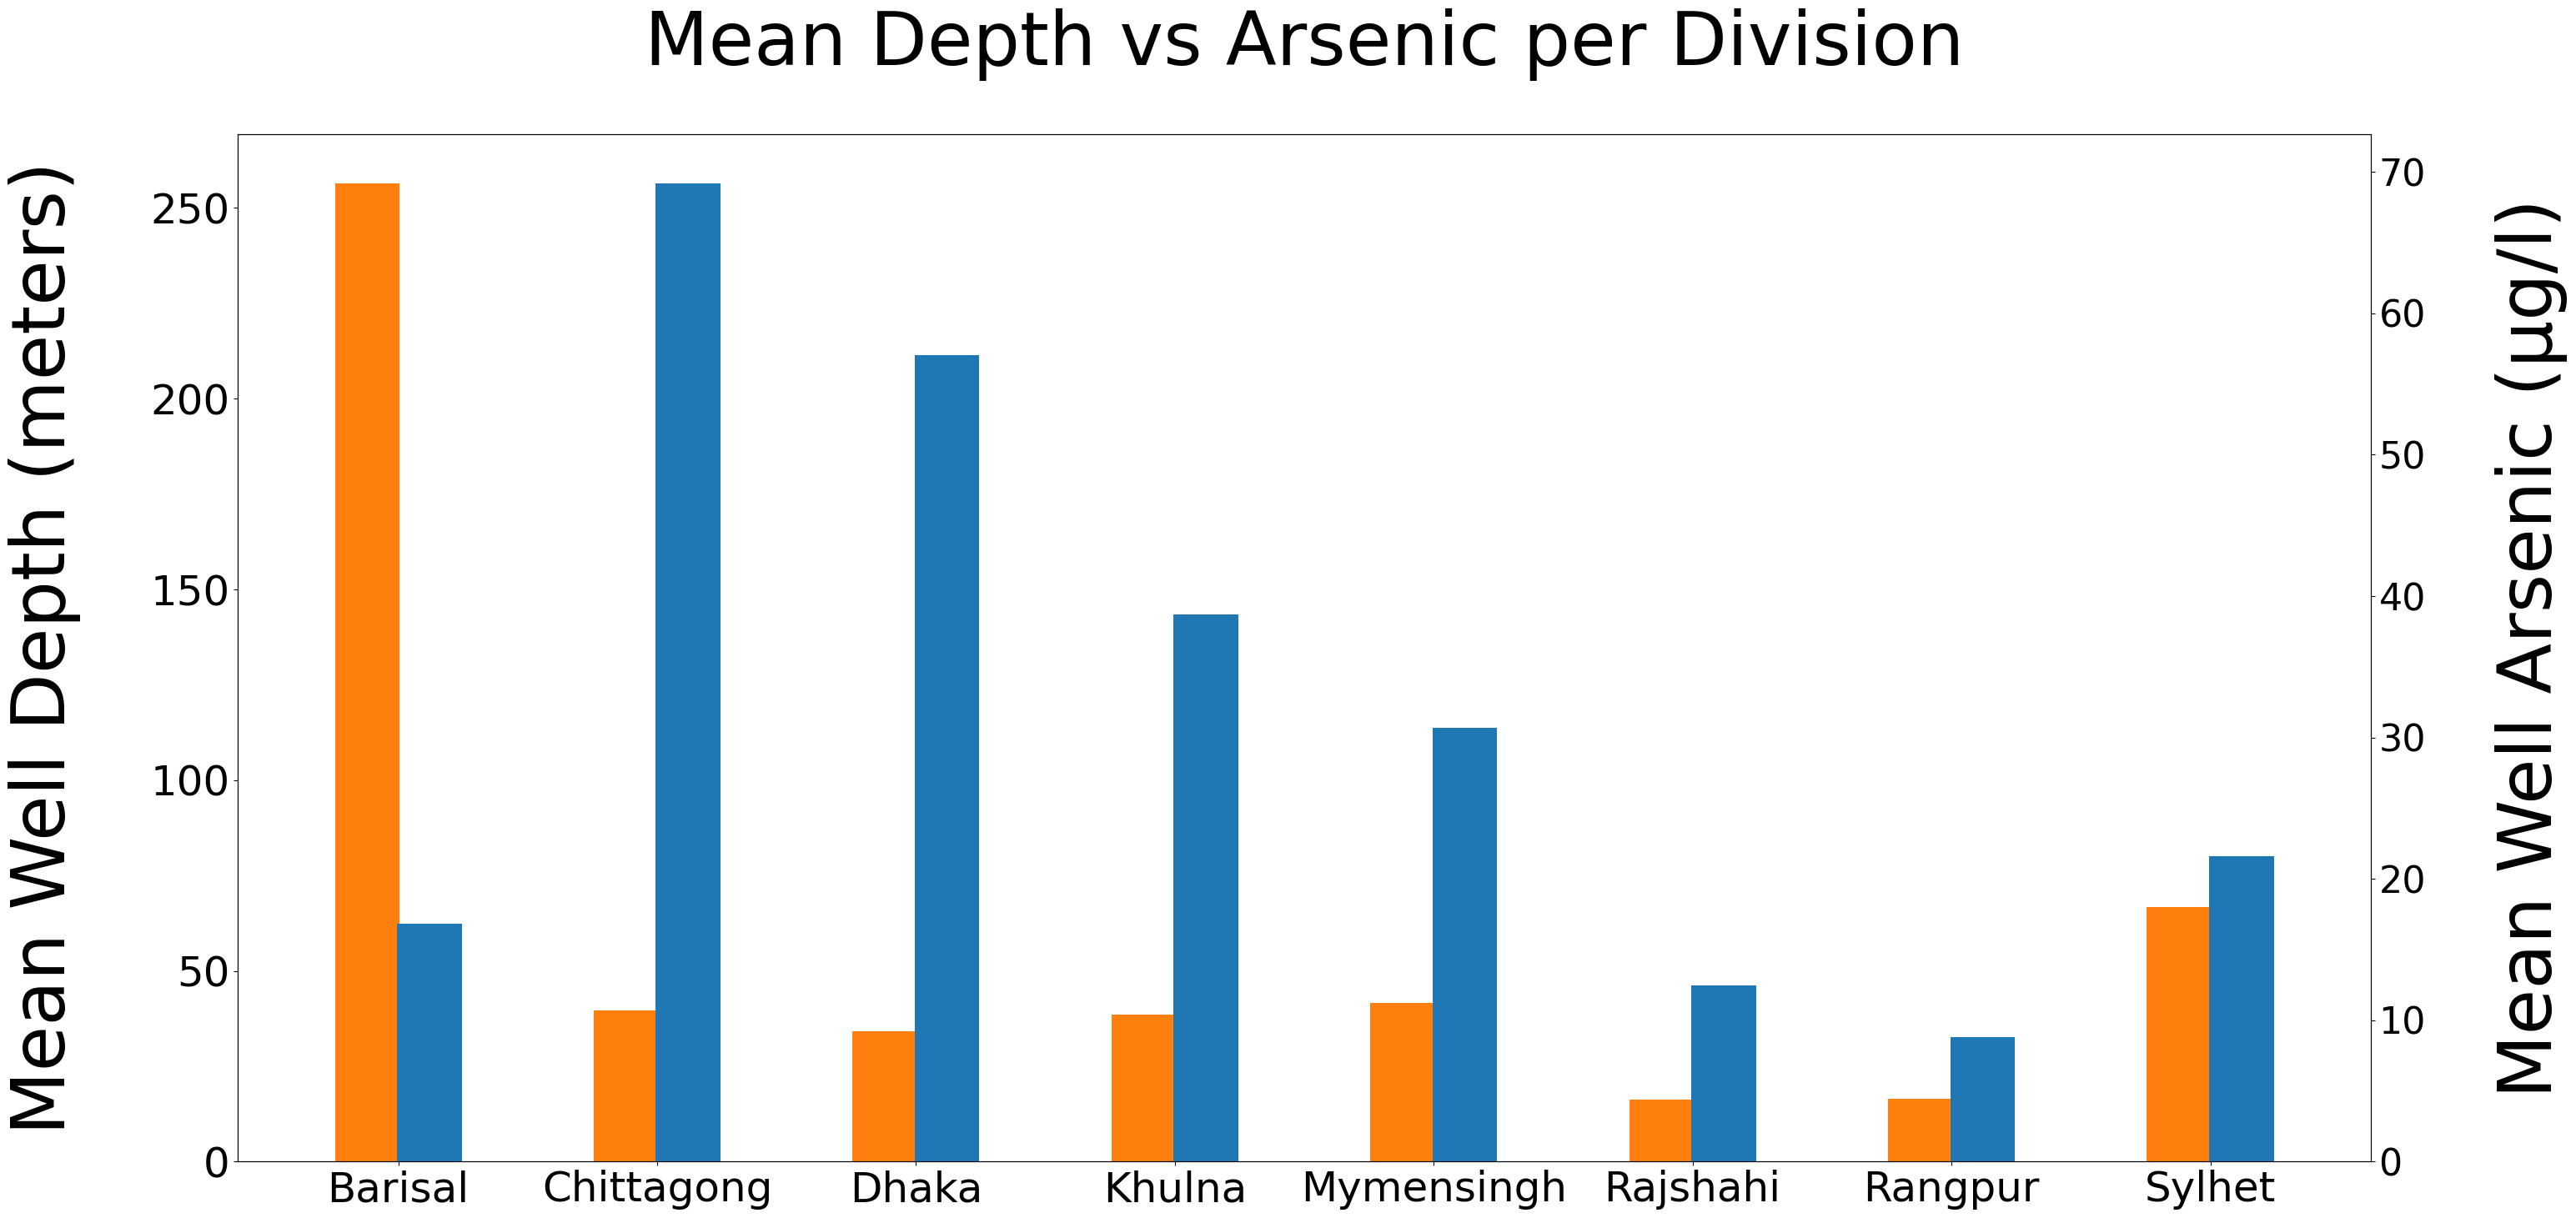

In [4]:
def depth_and_as_per_div():
    well_data = pd.read_csv(nc_src)
    agg_functions = {"Depth": "mean", "Arsenic": "mean"}
    div_agg_depth_as = well_data.groupby(well_data["Division"]).aggregate(agg_functions)
    
    fig, ax = plt.subplots(figsize=(33, 16))
    
    X = np.arange(len(div_agg_depth_as.index))
    ax.bar(X - 0.12, div_agg_depth_as['Depth'], color='tab:orange', width=0.25)
    
    ax2 = ax.twinx()
    ax2.bar(X + 0.12, div_agg_depth_as['Arsenic'], color='tab:blue', width=0.25)

    ax.set_ylabel('Mean Well Depth (meters)', fontsize=64, labelpad=60)
    ax2.set_ylabel('Mean Well Arsenic (µg/l)', fontsize=64, labelpad=60)

    ax.set_xticks(X, div_agg_depth_as.index.values, fontsize=36)
    
    ax.tick_params(axis='both', which='major', labelsize=36)
    ax.tick_params(axis='both', which='minor', labelsize=32)
    
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    
    plt.title('Mean Depth vs Arsenic per Division', fontsize=64, pad=60)
    plt.savefig('./poster/depth_and_as_per_div.png')
    
depth_and_as_per_div()

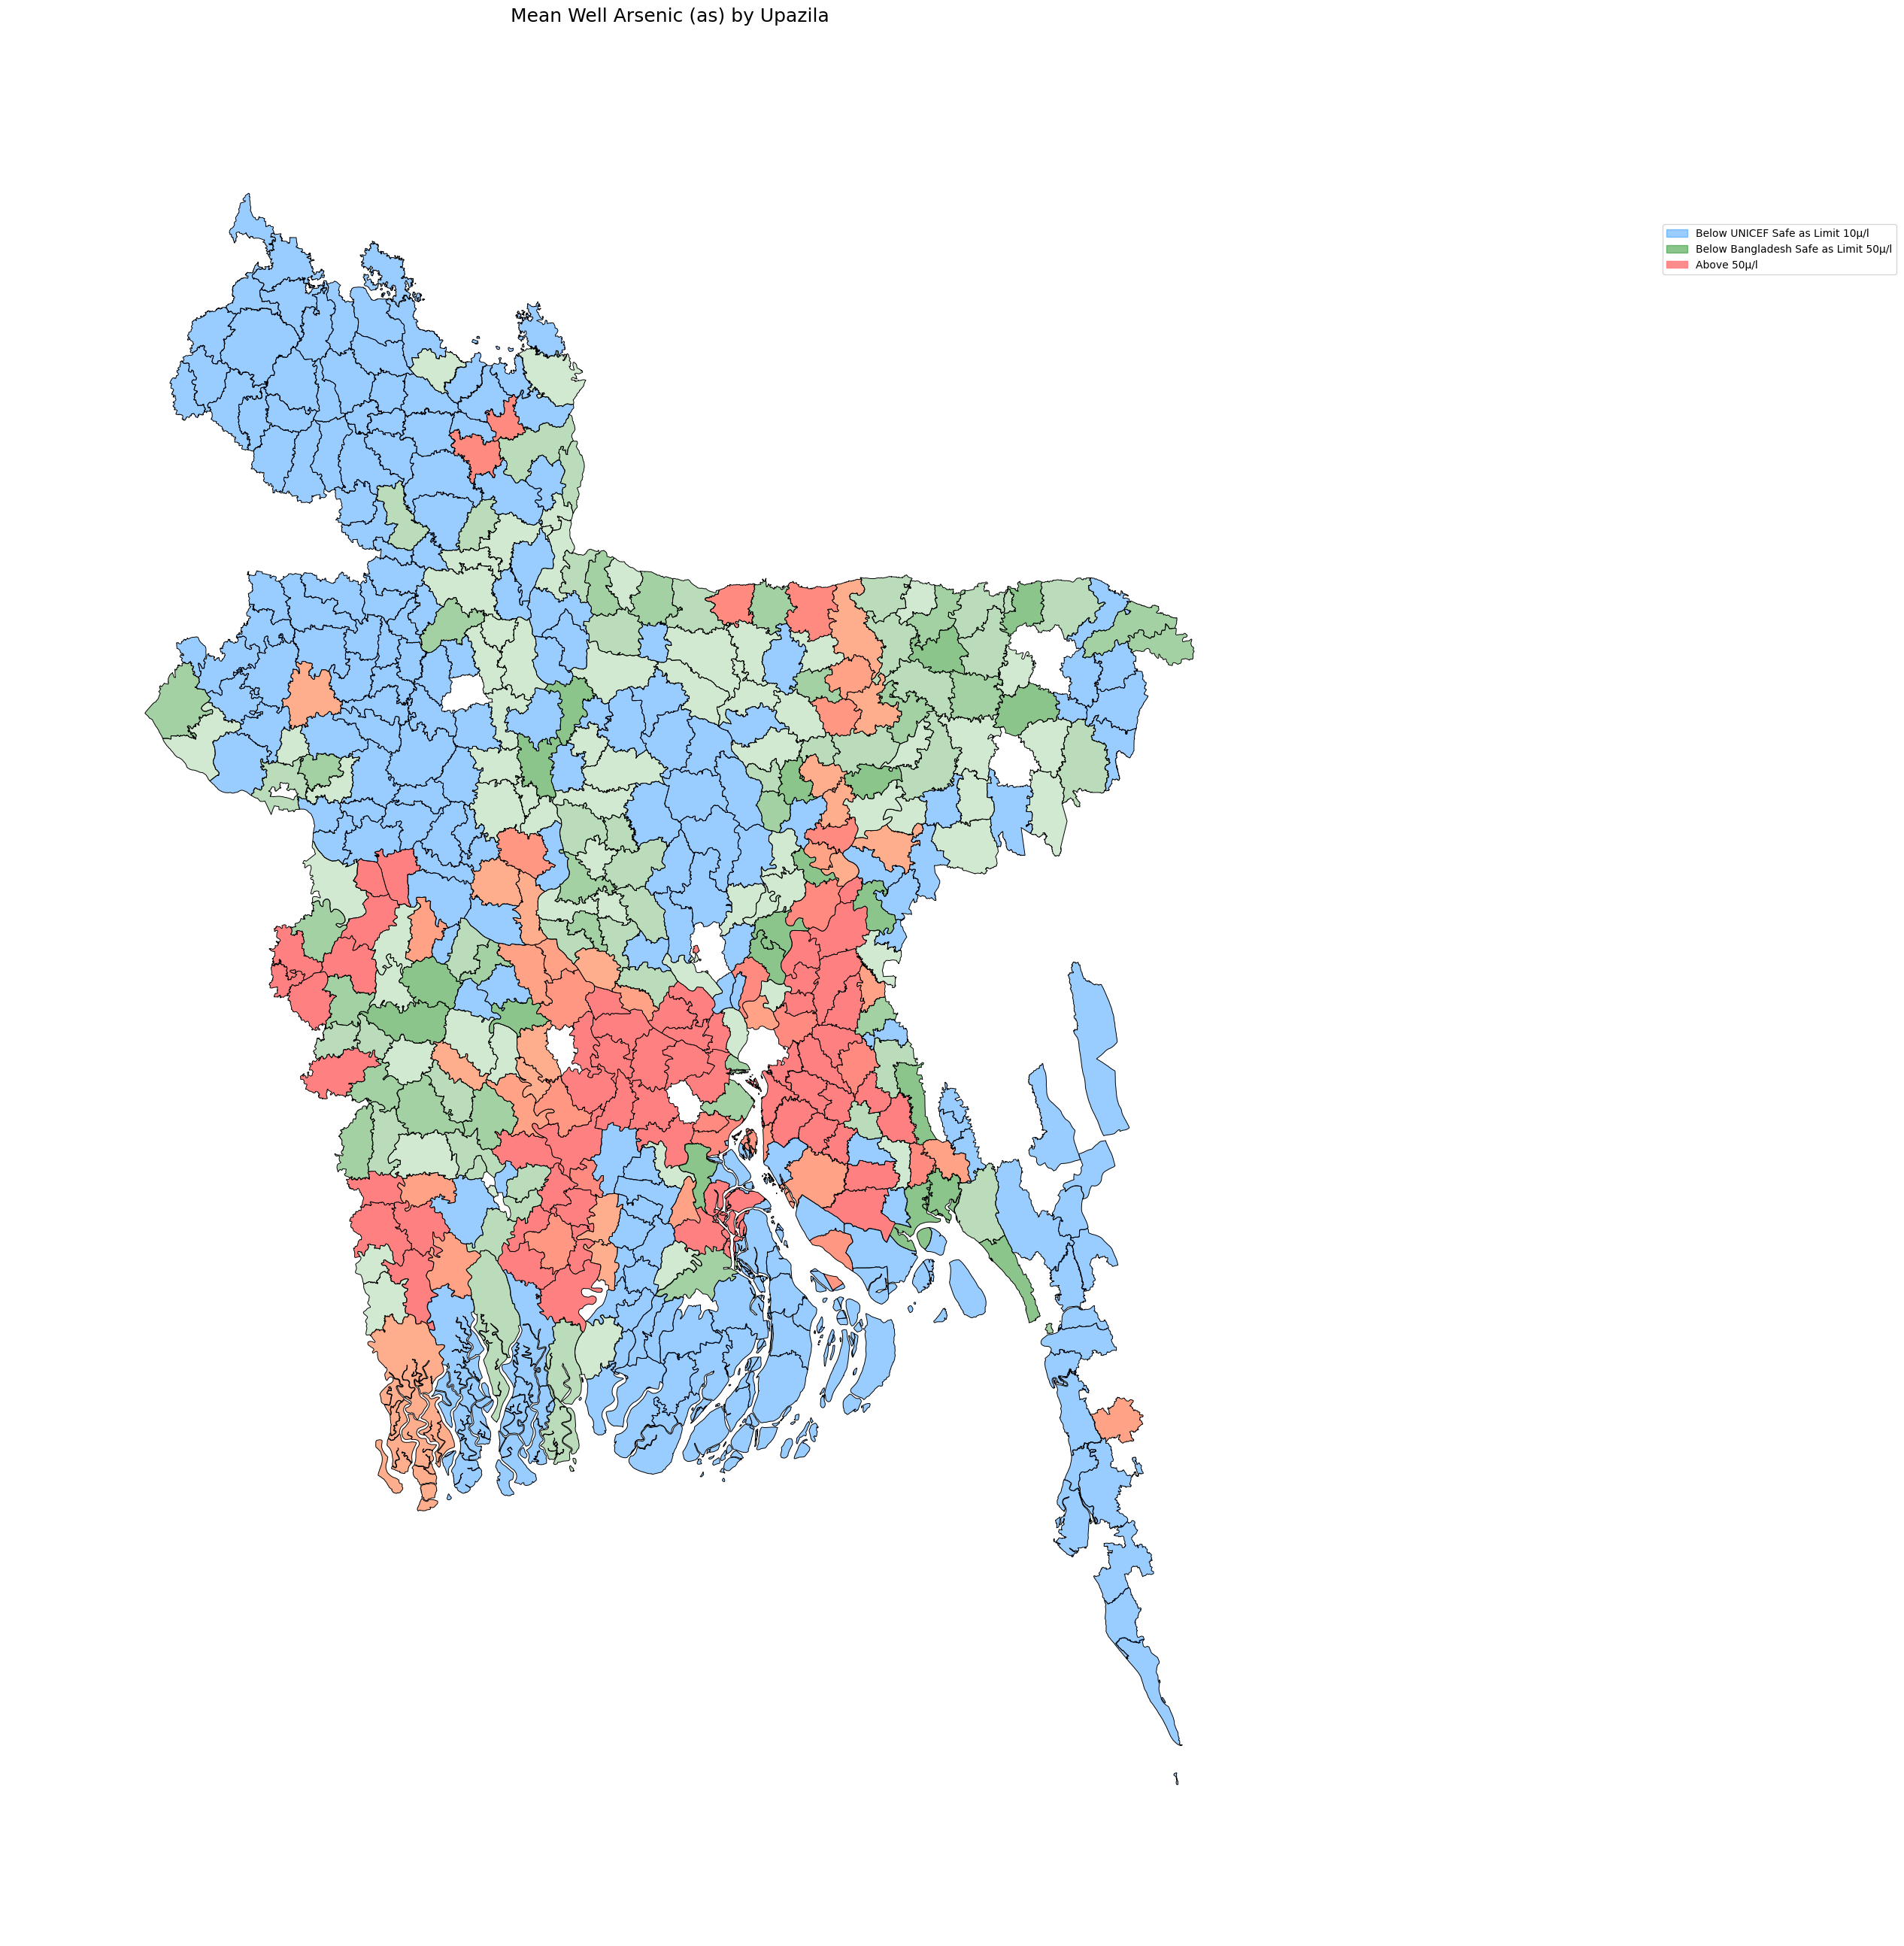

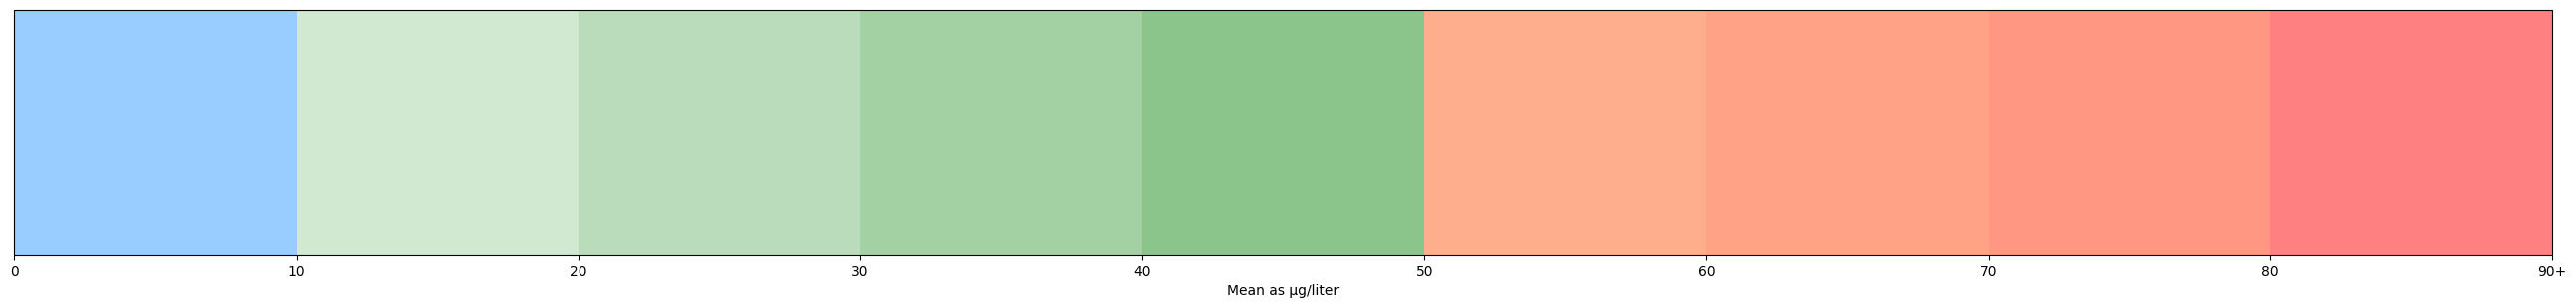

In [5]:
def mean_as_per_upa():
    well_data = pd.read_csv(nc_src)
    agg_functions = {"Arsenic": "mean"}
    agg_depth_as = well_data.groupby(well_data["Upazila"]).aggregate(agg_functions)
    agg_depth_as["Count"] = well_data.groupby(well_data["Upazila"]).size()

    gd = load_gd('upa')

    merged = pd.merge(agg_depth_as, gd, left_index=True, right_on="upa")
    gd_merged = gpd.GeoDataFrame(merged)

    # clip to keep color range compressed
    gd_merged["Arsenic_Clip"] = gd_merged["Arsenic"].clip(upper=100)

    # 0.99999 to avoid max value 1 but 1.00…02 found error
    scaler = MinMaxScaler(feature_range=(0.0, 0.99999))

    gd_merged["Arsenic_Scaled"] = scaler.fit_transform(gd_merged[["Arsenic_Clip"]])
        
    colors = {
        'Below UNICEF Safe as Limit 10μ/l': (0, 0.5, 1, 0.4), 
        'Below Bangladesh Safe as Limit 50μ/l': (0, 0.5, 0, 0.45),
        'Above 50μ/l': (1, 0.5, 0.5, 0.9),
    }         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]

    cmap = mpl.colors.ListedColormap([
        (0, 0.5, 1, 0.4), 
        (0, 0.5, 0, 0.18), 
        (0, 0.5, 0, 0.27), 
        (0, 0.5, 0, 0.36), 
        (0, 0.5, 0, 0.45), 
        (1, 0.5, 0.3, 0.64), 
        (1, 0.5, 0.35, 0.73), 
        (1, 0.5, 0.4, 0.82), 
        (1, 0.5, 0.45, 0.91), 
        (1, 0.5, 0.5, 1), 
    ])
    
    ax = gplt.choropleth(
        gd_merged,
        projection=gcrs.AlbersEqualArea(), 
        hue='Arsenic_Scaled',
        cmap=cmap, 
        figsize=(33,33),
        linewidth=0.7,
        edgecolor='black',
    )

    ax.legend(handles, labels, bbox_to_anchor=(1.43, 0.9))
    ax.set_title('Mean Well Arsenic (as) by Upazila', fontsize=18)
    
    plt.savefig('./poster/mean_as_by_upa.png')

    fig, ax = plt.subplots(figsize=(33, 6.5))
    fig.subplots_adjust(bottom=0.5)
    
    bounds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    cb2 = mpl.colorbar.ColorbarBase(
        ax, 
        cmap=cmap,
        norm=norm,
        spacing='proportional',
        orientation='horizontal',
        label='Mean as μg/liter',
    )
    
    as_ticklabels = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90+']
    cb2.set_ticklabels(
        as_ticklabels
    )
    
    plt.savefig('./poster/mean_as_by_upa_cbar.png')

mean_as_per_upa()

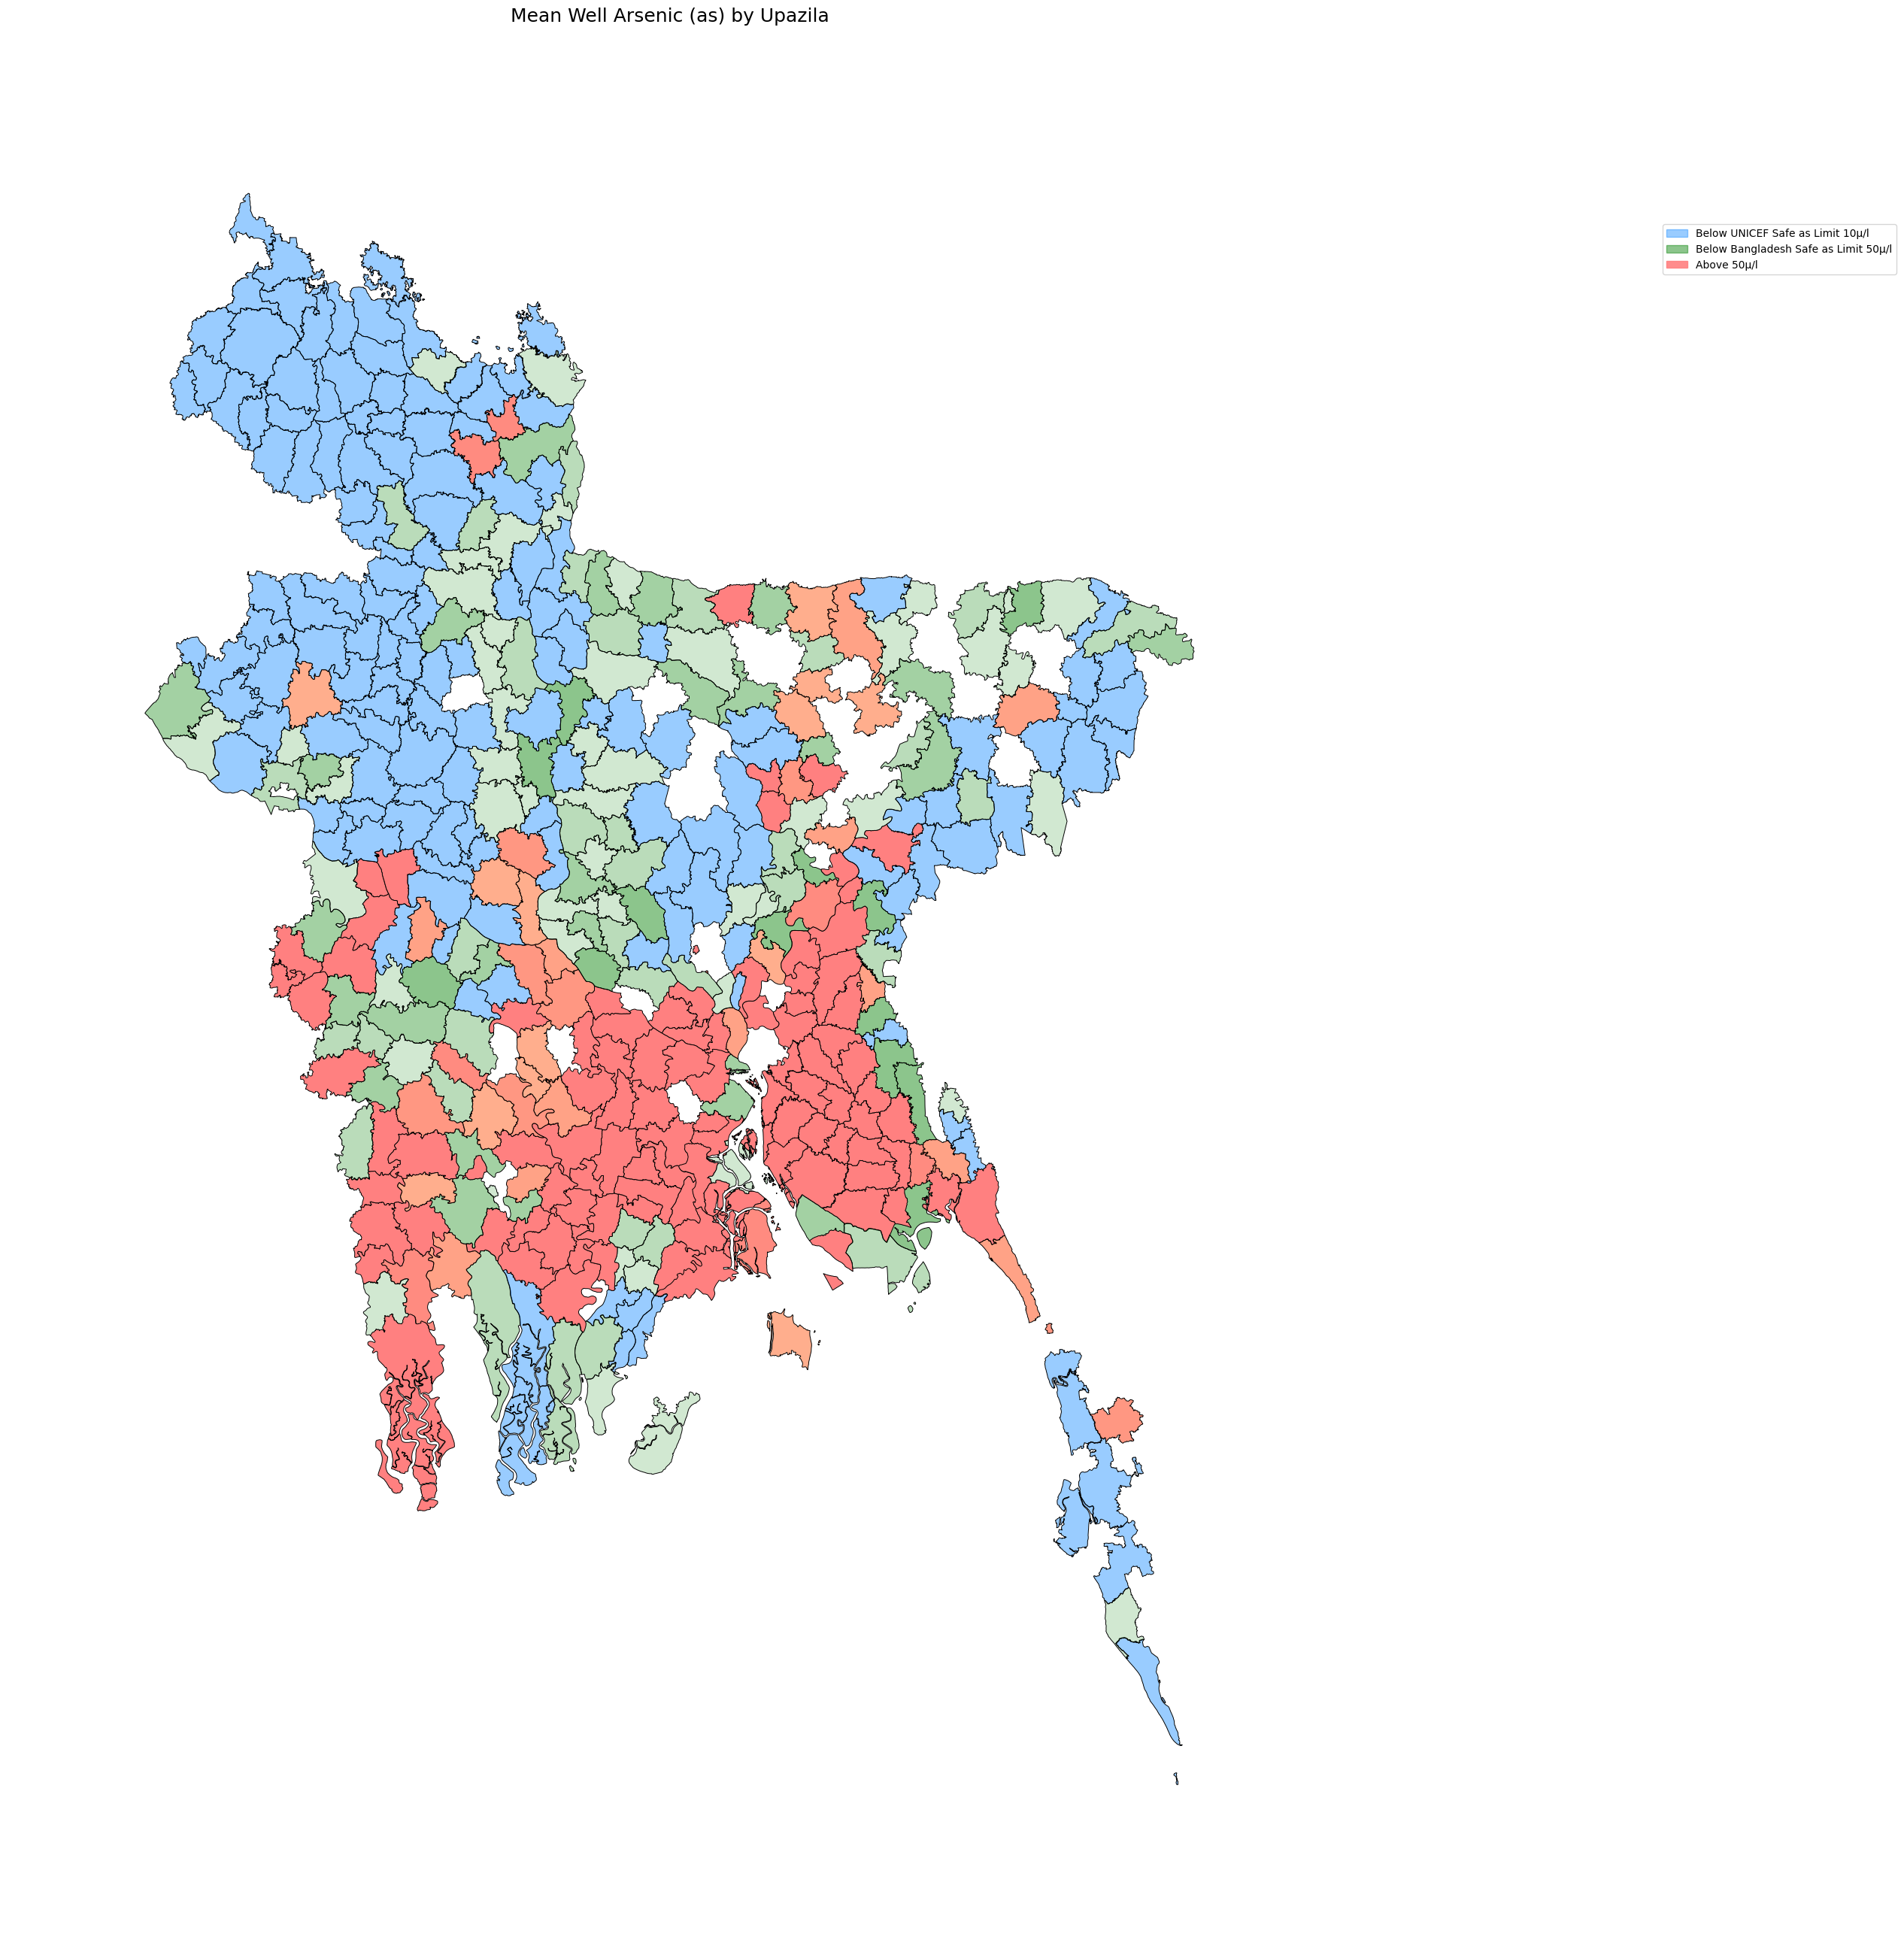

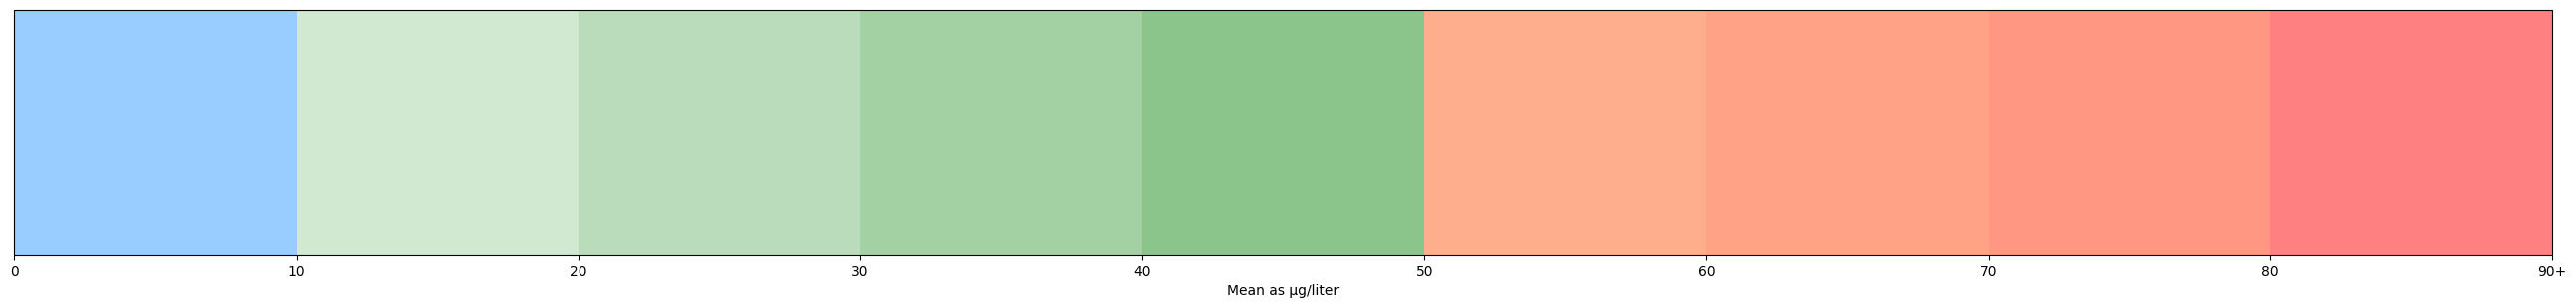

In [6]:
def mean_as_per_upa():
    well_data = pd.read_csv(nc_src)
    df = well_data[well_data['Depth'] <= 50]
    agg_functions = {"Arsenic": "mean"}
    agg_depth_as = df.groupby(well_data["Upazila"]).aggregate(agg_functions)
    agg_depth_as["Count"] = df.groupby(df["Upazila"]).size()

    gd = load_gd('upa')

    merged = pd.merge(agg_depth_as, gd, left_index=True, right_on="upa")
    gd_merged = gpd.GeoDataFrame(merged)

    # clip to keep color range compressed
    gd_merged["Arsenic_Clip"] = gd_merged["Arsenic"].clip(upper=100)

    # 0.99999 to avoid max value 1 but 1.00…02 found error
    scaler = MinMaxScaler(feature_range=(0.0, 0.99999))

    gd_merged["Arsenic_Scaled"] = scaler.fit_transform(gd_merged[["Arsenic_Clip"]])
        
    colors = {
        'Below UNICEF Safe as Limit 10μ/l': (0, 0.5, 1, 0.4), 
        'Below Bangladesh Safe as Limit 50μ/l': (0, 0.5, 0, 0.45),
        'Above 50μ/l': (1, 0.5, 0.5, 0.9),
    }         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]

    cmap = mpl.colors.ListedColormap([
        (0, 0.5, 1, 0.4), 
        (0, 0.5, 0, 0.18), 
        (0, 0.5, 0, 0.27), 
        (0, 0.5, 0, 0.36), 
        (0, 0.5, 0, 0.45), 
        (1, 0.5, 0.3, 0.64), 
        (1, 0.5, 0.35, 0.73), 
        (1, 0.5, 0.4, 0.82), 
        (1, 0.5, 0.45, 0.91), 
        (1, 0.5, 0.5, 1), 
    ])
    
    ax = gplt.choropleth(
        gd_merged,
        projection=gcrs.AlbersEqualArea(), 
        hue='Arsenic_Scaled',
        cmap=cmap, 
        figsize=(33,33),
        linewidth=0.7,
        edgecolor='black',
    )

    ax.legend(handles, labels, bbox_to_anchor=(1.43, 0.9))
    ax.set_title('Mean Well Arsenic (as) by Upazila', fontsize=18)
    
    plt.savefig('./poster/mean_as_by_upa_depth_100.png')

    fig, ax = plt.subplots(figsize=(33, 6.5))
    fig.subplots_adjust(bottom=0.5)
    
    bounds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    cb2 = mpl.colorbar.ColorbarBase(
        ax, 
        cmap=cmap,
        norm=norm,
        spacing='proportional',
        orientation='horizontal',
        label='Mean as μg/liter',
    )
    
    as_ticklabels = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90+']
    cb2.set_ticklabels(
        as_ticklabels
    )
    
    plt.savefig('./poster/mean_as_by_upa_depth_100_cbar.png')

mean_as_per_upa()

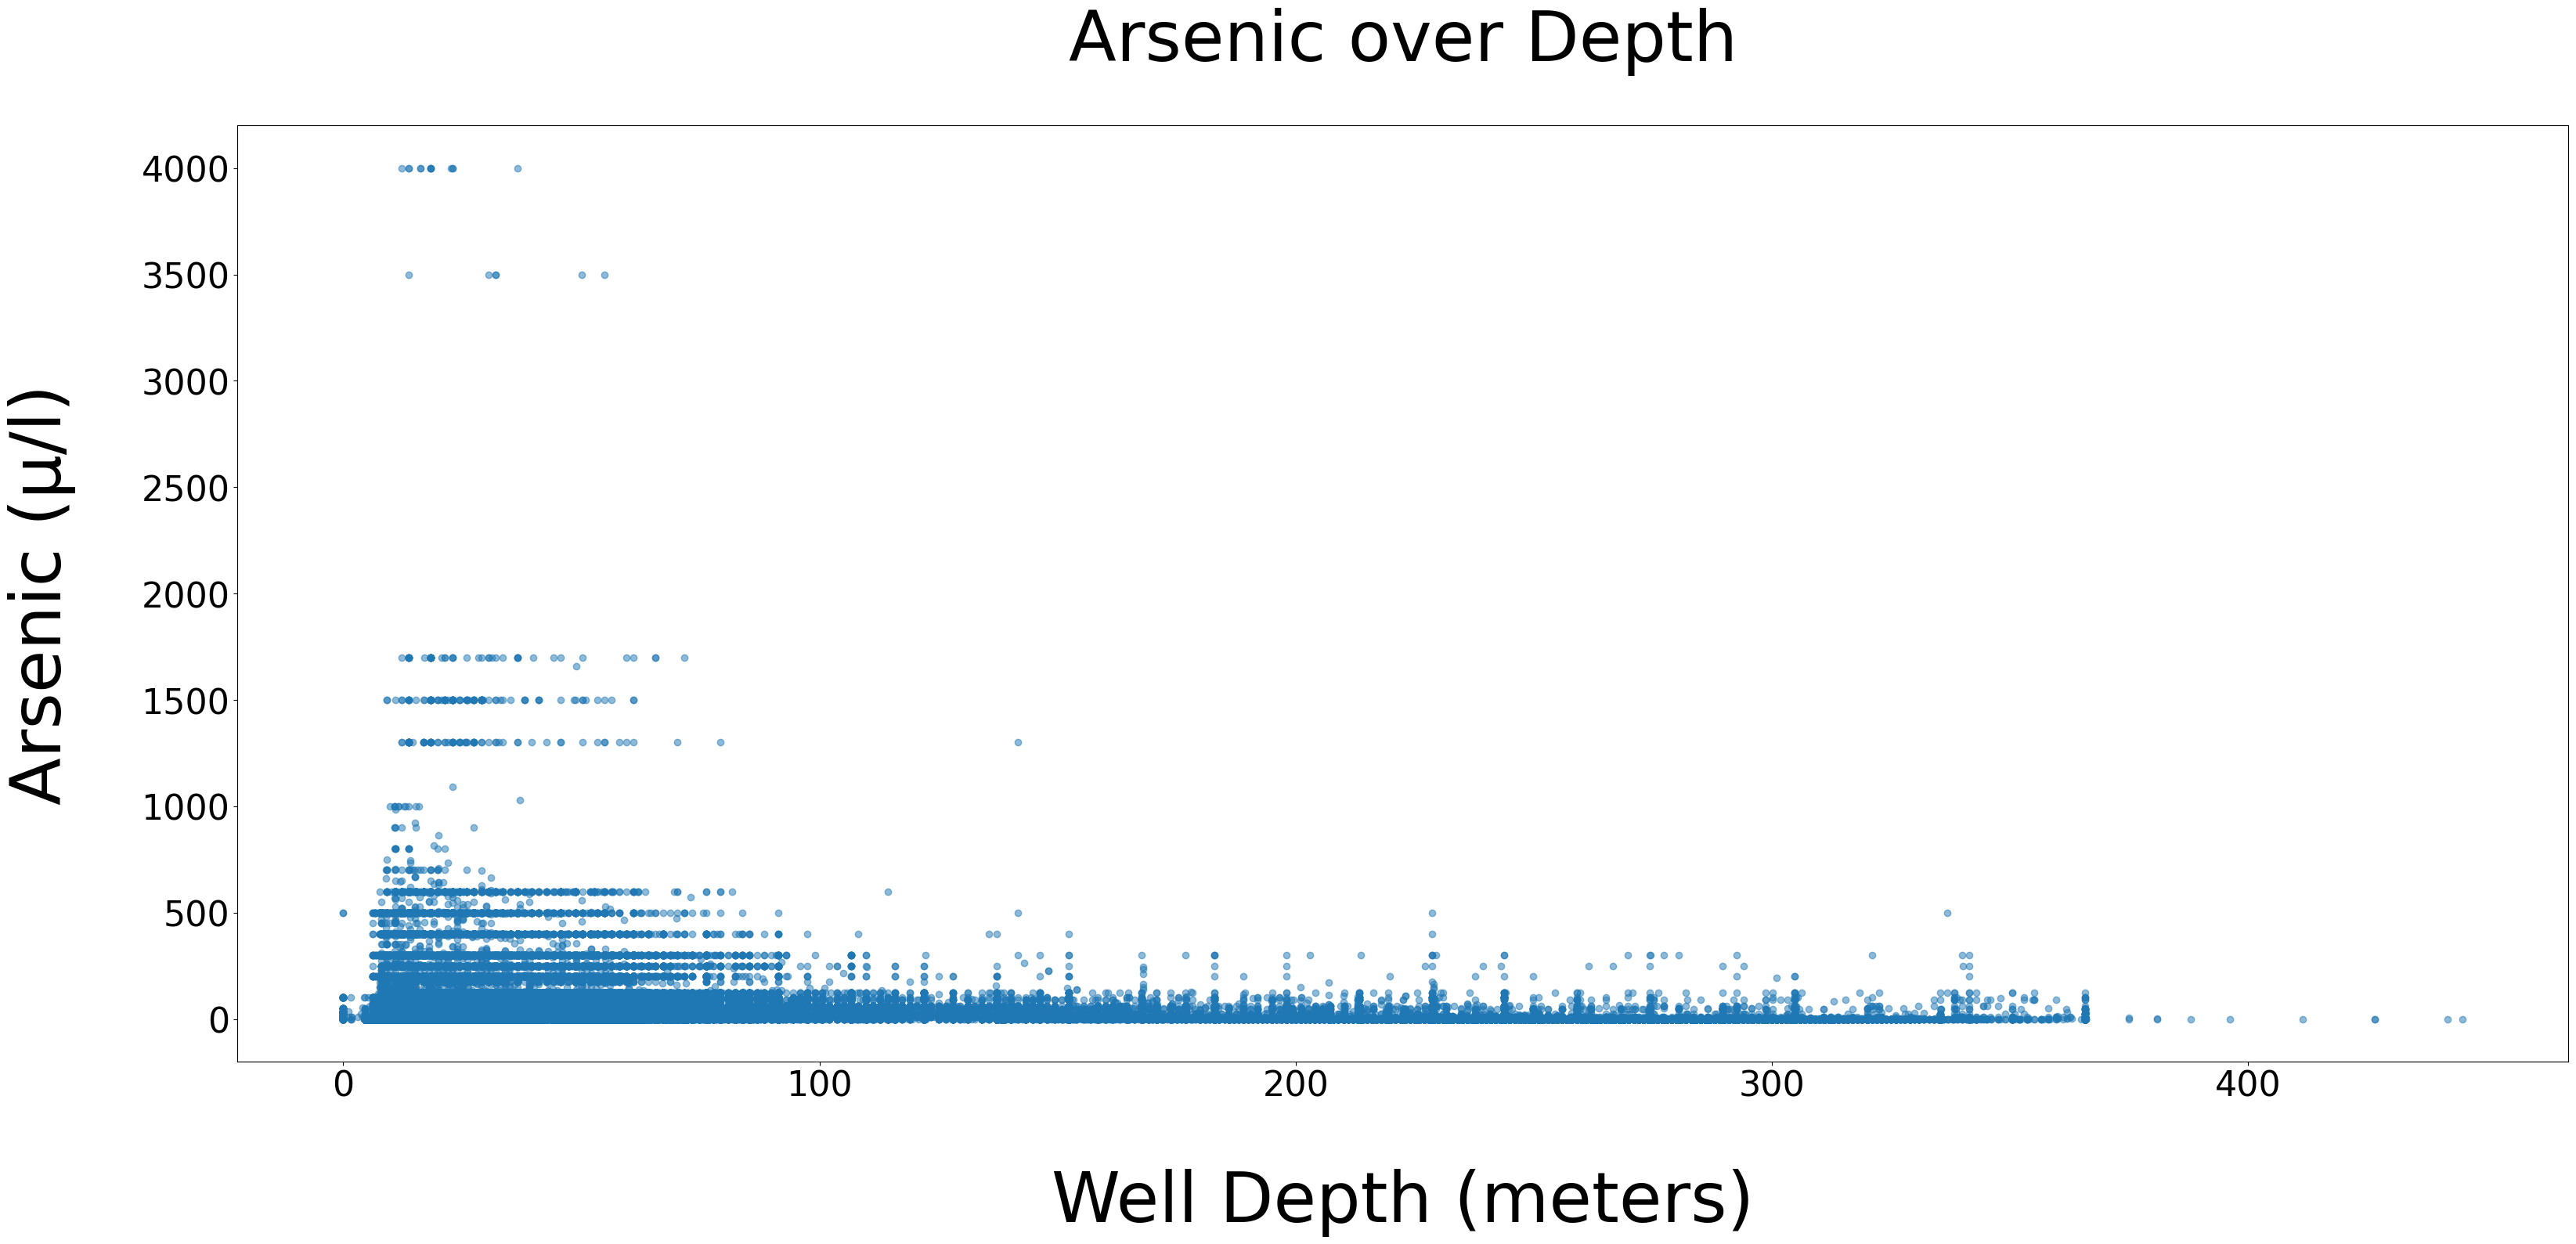

In [12]:
def as_over_depth():
    df = pd.read_csv(nc_src)

    fig, ax = plt.subplots(figsize=(33, 16))
    
    plt.scatter(df['Depth'], df['Arsenic'], alpha=0.5)
    ax.set_ylabel('Arsenic (μ/l)', fontsize=64, labelpad=60)
    ax.set_xlabel('Well Depth (meters)', fontsize=64, labelpad=60)
    
    ax.tick_params(axis='both', which='major', labelsize=36)
    ax.tick_params(axis='both', which='minor', labelsize=32)
    
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    
    plt.title('Arsenic over Depth', fontsize=64, pad=60)
    plt.tight_layout()
    plt.savefig('./poster/as_over_depth.png')
    
as_over_depth()

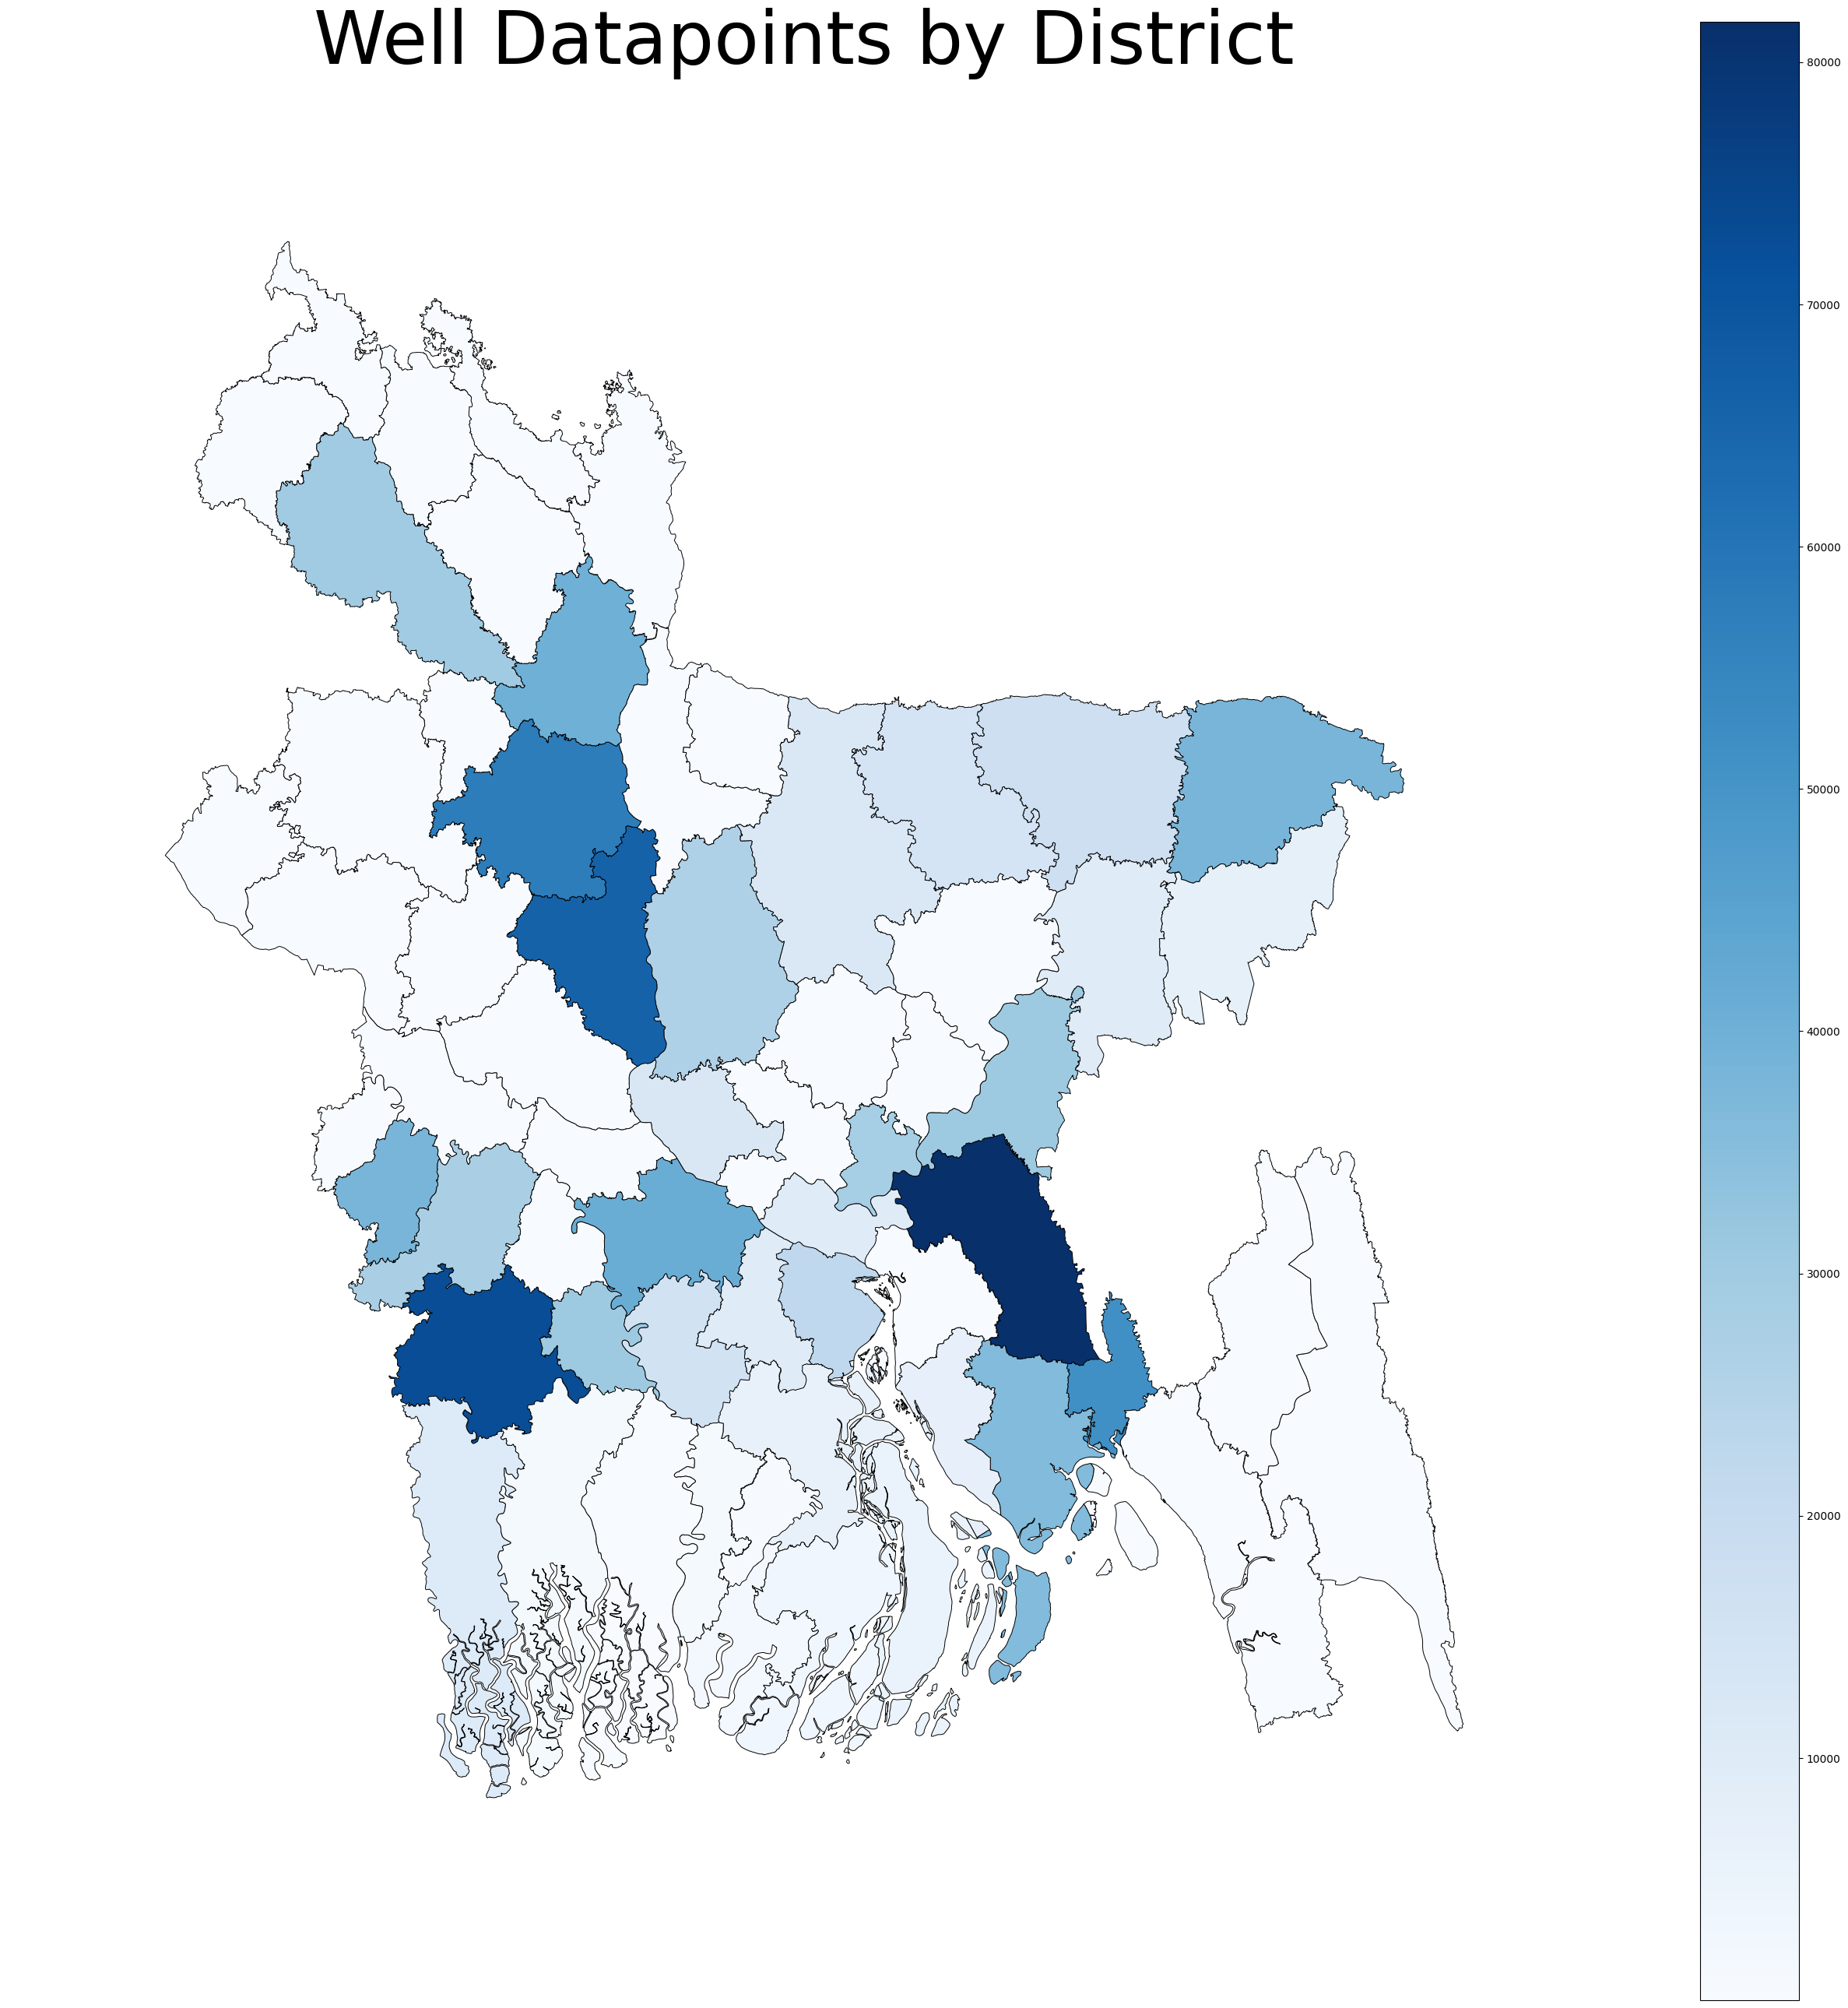

In [8]:
def datapoints_per_upa_map():
    well_data = pd.read_csv(nc_src)
    gd = load_gd('dis')
    datapoints = well_data['District'].value_counts()

    merged = pd.merge(datapoints, gd, left_index=True, right_on="dis")
    gd_merged = gpd.GeoDataFrame(merged)

    # clip to keep color range compressed
    gd_merged["District"] = gd_merged["District"]
    
    ax = gplt.choropleth(
        gd_merged,
        projection=gcrs.AlbersEqualArea(), 
        hue='District',
        cmap='Blues', 
        figsize=(33,33),
        linewidth=0.7,
        edgecolor='black',
        legend=True
    )
    
    ax.set_title('Well Datapoints by District', fontsize=68)
    plt.savefig('./poster/dp_per_dis.png')
    
datapoints_per_upa_map()